# Assignment 3: Technical Report
## Finding fast growing firms!

> Summary report and data can be found on my [GitHub page](https://github.com/RamziChariag/Prediction-ML)

Task is to build a model to predict fast growth of firms using the bisnode-firms data

* You should design the target (fast growth), it can be measured in any way you like over one (2013 vs 2012) or two years (2014 vs 2012)

* You need to argue for your choice, discussing a few alternatives.

* Build three different models and pick the one you like the most
 * Should include at least one logit and one random forest
 
### PART I: Probability prediction
* Predict probabilities
* Look at cross-validated performance and pick your favorite model

### PART II: Classification
* Think about the business problem, and define your loss function (like FP=X dollars, FN=Y dollars)
* For each model, predict probabilities, look for the optimal classification threshold, calculate expected loss with your loss function. 
* Pick the model that has the smallest average (over 5 folds) expected loss

### PART III Discussion of results
* Show a confusion table (on a selected fold or holdout set)
* Discuss results, evaluate how useful your model may be

## Scoring

* Data prep, label and feature engineering (25%)
* Model building and probability prediction and model selection (25%)
* Classification (20%)

* Discussion of steps, decisions and results (15%)
    * Explain shortly every modelling decisions
    * At the end please give a 2-3 paragraph discussion of what you found.

* Quality of the write-up (15%)

# Part 0: Preparing Data
## Importing Data

The first thing to be done is to get data, import it, and keep only the variables and observations I need for models

In [1]:
### SETTING UP DIRECTORIES

# import packages
import pandas as pd
import os
import numpy as np
import sys
import warnings
from pathlib import Path
import patsy

from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
import seaborn as sns
from mizani.formatters import percent_format
import regex as re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")

# set working directory 
os.chdir('/Users/ramzi.chariag/Documents/CEU/PhD/ML prediction/assignment_3/')

# location folders
data_in = "/Users/ramzi.chariag/Documents/CEU/PhD/ML prediction/assignment_3/data"
data_out = "/Users/ramzi.chariag/Documents/CEU/PhD/ML prediction/assignment_3/data"
results = "/Users/ramzi.chariag/Documents/CEU/PhD/ML prediction/assignment_3/output"
func = '/Users/ramzi.chariag/Documents/CEU/PhD/ML prediction/assignment_3/'

sys.path.append(func)
from py_helper_functions import *

In [2]:
os.getcwd()

'/Users/ramzi.chariag/Documents/CEU/PhD/ML prediction/assignment_3'

In [3]:
# read csv
current_csv_path = os.path.join(data_in,"cs_bisnode_panel.csv")
data = pd.read_csv(current_csv_path)
data

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1.001034e+06,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1.001034e+06,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1.001034e+06,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1.001034e+06,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1.001034e+06,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287824,4.641209e+11,2011-01-01,2011-12-31,NaN,0.000000,1807.407349,3.703704,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287825,4.641209e+11,2012-01-01,2012-12-31,NaN,0.000000,1518.518555,96.296295,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287826,4.641209e+11,2013-01-01,2013-12-31,NaN,0.000000,988.888916,77.777779,0.0,0.0,0.0,...,NaN,NaN,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287827,4.641209e+11,2014-01-01,2014-12-31,NaN,0.000000,644.444458,233.333328,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN


The data has 287,829 rows and 48 columns. We need to start with the panel for 2010-2015. Let's delete all other years.

In [4]:
data=data.query('year<=2015 & year>=2010')

Now we are left with 167,606 observations

Look at variables with many missing variables

`data.isnull().sum()` shows that 'COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', and 'D' have a lot of missing values (more than 90%). I will delete these columns

In [5]:
# Set options to see all rows and columns
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [6]:
# drop columns with many NAs
data = data.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D'])

## Target variable
I define fast growing firm as the firm which has high percentage change in sales over a period of time.

As I expect the distribution of sales to be skewed, I might swith to log values. 

In [7]:
data['sales'].describe()

count    1.638640e+05
mean     4.662059e+05
std      3.789100e+06
min     -2.553889e+05
25%      3.092593e+03
50%      2.697037e+04
75%      1.060620e+05
max      1.110294e+08
Name: sales, dtype: float64

There are negative values of sales. I will replace them with 0.

I will also create a log of sales variable

In [8]:
# replace negative values with zeros
data['sales']=np.where(data['sales'] < 0, 1, data['sales'])
# create log of sales
data = data.assign(
    ln_sales = np.where(data['sales'] > 0 , np.log(data['sales']), (np.where(data['sales'].isna(),np.nan,0))), #NaN remain NaN
  )

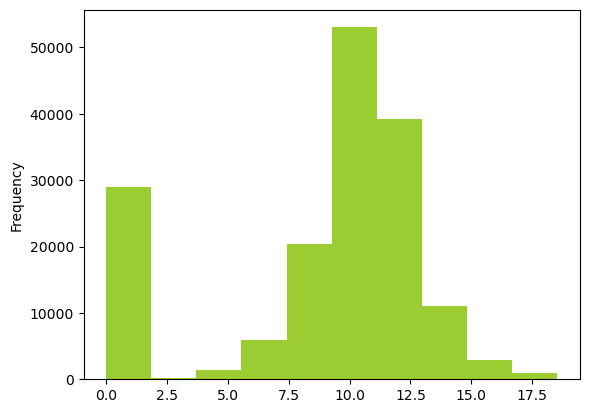

In [9]:
ax=data['ln_sales'].plot(kind='hist', color='#9BCC31')

In [10]:
# create changes of ln_sales from 2011 to 2012
data['diff_ln_sales']=data['ln_sales']-data.groupby('comp_id')['ln_sales'].shift(1)

In [11]:
# create age and new variables
data['age']=np.where(data['year']-data['founded_year'] < 0, 0, data['year']-data['founded_year'])
data['new']=np.where(((data['age']<=1)|(data['balsheet_notfullyear']==1)),1,(np.where(data['age'].isna(),np.nan,0)))

# adjust 
data["diff_ln_sales"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["diff_ln_sales"])
)
data["new"] = np.where(data["diff_ln_sales"].isna(), 1, data["new"])
data["diff_ln_sales"] = np.where(
    data["diff_ln_sales"].isna(), 0, data["diff_ln_sales"]
)

In [12]:
# create percentage changes of ln_sales from 2012 to 2013 and from 2012 to 2014 
data['d1_ln_sales'] = (data.groupby('comp_id')['ln_sales'].shift(-1) - data['ln_sales'] )/ data['ln_sales']
data['d2_ln_sales'] = (data.groupby('comp_id')['ln_sales'].shift(-2) - data['ln_sales'] )/ data['ln_sales']

# create percentage changes of sales from 2012 to 2013 and from 2012 to 2014 
data['d1_sales'] = (data.groupby('comp_id')['sales'].shift(-1) - data['sales'] )/ data['sales']
data['d2_sales'] = (data.groupby('comp_id')['sales'].shift(-2) - data['sales'] )/ data['sales']

Now look at cross-section

In [13]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data['status_alive'] = (data['sales'] > 0 & (False == data['sales'].isna())).astype(int)

# look at cross section
data=data.query('year==2012 & status_alive == 1')

# look at firms below 10m euro revenues and above 1000 euros
data=data.query('sales <= 10000000 & sales>=1000')
data

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,labor_avg,ln_sales,diff_ln_sales,age,new,d1_ln_sales,d2_ln_sales,d1_sales,d2_sales,status_alive
14,1.001541e+06,2012-01-01,2012-12-31,481.481476,9.629630e+03,1.303704e+03,0.000000,0.000000,0.000000,190566.671875,...,NaN,7.093159,7.093159,4.0,0.0,0.215616,0.197593,3.615385,3.061538,1
23,1.002029e+06,2012-01-01,2012-12-31,14929.629883,2.038852e+05,1.204445e+05,0.000000,0.000000,0.000000,23459.259766,...,0.458333,13.943477,0.684448,6.0,0.0,-0.082835,-0.118835,-0.684947,-0.809284,1
35,1.003200e+06,2012-01-01,2012-12-31,25.925926,2.222222e+01,1.099630e+04,0.000000,0.000000,0.000000,0.000000,...,NaN,7.932070,-1.424773,9.0,0.0,NaN,NaN,NaN,NaN,1
56,1.011889e+06,2012-01-01,2012-12-31,36625.925781,1.601667e+05,1.891111e+04,0.000000,0.000000,0.000000,933574.062500,...,1.621212,12.980031,0.097722,20.0,0.0,0.001472,0.006666,0.019293,0.090375,1
68,1.014183e+06,2012-01-01,2012-12-31,12551.851562,1.999037e+05,8.274074e+03,0.000000,7.407407,7.407407,118229.632812,...,0.715278,11.773208,-0.273087,11.0,0.0,-0.009347,-0.021219,-0.104205,-0.221058,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287764,4.638854e+11,2012-01-01,2012-12-31,544.444458,1.437407e+04,1.330000e+04,0.000000,0.000000,0.000000,7985.185059,...,0.121212,11.958560,-0.234990,3.0,0.0,0.071992,0.116584,1.365346,3.031641,1
287779,4.639820e+11,2012-01-01,2012-12-31,16337.037109,3.140000e+04,8.300000e+03,0.000000,0.000000,0.000000,113266.656250,...,0.548611,12.159136,-0.844769,17.0,0.0,0.054497,0.070672,0.939912,1.361540,1
287790,4.640212e+11,2012-01-01,2012-12-31,3566.666748,3.149630e+04,1.783704e+04,0.000000,0.000000,0.000000,31707.408203,...,0.083333,10.546608,-0.282607,6.0,0.0,0.040499,0.031267,0.532853,0.390636,1
287798,4.640446e+11,2012-01-01,2012-12-31,76059.257812,4.776548e+06,1.297552e+06,0.000000,0.000000,0.000000,286355.562500,...,1.840278,15.959566,0.294490,4.0,0.0,0.000762,0.004195,0.012234,0.069247,1


Now we are left with 21,723 observations.

It's time to define a *fast_growth* variable, which is 1 for firms who has at least 20% growth in sales every year. That is where *d1_sales* $\ge 0.2$ and *d2_sales* $\ge 0.44$ (because $1.2*1.2 = 1.44$)

In [14]:
data["fast_growth"] = (
    (data["d1_sales"] >= 0.2)
    & (data["d2_sales"] >= 0.44)
).astype(int)

In [15]:
print("The number of fast growing firms is {} which is {:.2f} percent of all firms".format(data.fast_growth.sum(), 100*data.fast_growth.sum()/len(data)))

The number of fast growing firms is 3751 which is 17.27 percent of all firms


## Feature Engineering

I will create extra variables for the models here

In [16]:
# change some industry category codes
data['ind2_cat']=data['ind2'].copy()
data['ind2_cat']=np.where(data['ind2']>56,60,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']<26,20,data['ind2_cat'])
data['ind2_cat']=np.where((data['ind2']<55)&(data['ind2']>35),40,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']==31,30,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2'].isna(),99,data['ind2_cat'])

In [17]:
# Firm characteristics
data['age2'] = data['age']**2
data['foreign_management'] = np.where(data['foreign'] >= 0.5, 1, np.where(data['foreign'].isna(), np.nan, 0))
data['gender_m'] = data['gender'].astype("category")
data['m_region_loc'] = data['region_m'].astype("category")

In [18]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data['flag_asset_problem'] = np.where(((data['intang_assets'] < 0) | (data['curr_assets'] < 0) | (data['fixed_assets'] < 0)), 1, 0)
data['flag_asset_problem'] = np.where(((data['intang_assets'].isna()) | (data['curr_assets'].isna()) | (data['fixed_assets'].isna())), np.nan, data['flag_asset_problem'])
data.groupby('flag_asset_problem').count()['comp_id']

flag_asset_problem
0.0    21700
1.0       13
Name: comp_id, dtype: int64

In [19]:
data['intang_assets'] = np.where(data['intang_assets'] < 0, 0, data['intang_assets'])
data['curr_assets'] = np.where(data['curr_assets'] < 0, 0, data['curr_assets'])
data['fixed_assets'] = np.where(data['fixed_assets'] < 0, 0, data['fixed_assets'])

In [20]:
# generate total assets
data['total_assets_bs'] = data['intang_assets'] + data['curr_assets'] + data['fixed_assets']
data['total_assets_bs'].describe()

count    2.171300e+04
mean     2.525889e+05
std      1.383198e+06
min      0.000000e+00
25%      6.466667e+03
50%      2.382963e+04
75%      9.346296e+04
max      1.046833e+08
Name: total_assets_bs, dtype: float64

In [21]:
pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [22]:
# divide all pl_names elements by sales and create new column for it
data['total_assets_bs']

14        2.001963e+05
23        2.273444e+05
35        2.222222e+01
56        1.095278e+06
68        3.181333e+05
              ...     
287764    2.235926e+04
287779    1.446667e+05
287790    6.320371e+04
287798    5.062904e+06
287814    4.074074e+04
Name: total_assets_bs, Length: 21723, dtype: float64

In [23]:
# divide all pl_names elements by sales and create new column for it
data[[col +'_pl' for col in pl_names]] = data[pl_names].div(data['sales'], axis='index')

In [24]:
data['total_assets_bs'].isna().sum()

10

Since the number of missings is not that high, I impute them with the mean

In [25]:
# Mean Imputation

mean_imputer = SimpleImputer(strategy='mean')
data['total_assets_bs'] = mean_imputer.fit_transform(data['total_assets_bs'].values.reshape(-1,1))

In [26]:
data['total_assets_bs'].isna().sum()

0

In [27]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col +'_bs' for col in bs_names]] =  data[bs_names].div(data['total_assets_bs'], axis='index').replace((np.inf, -np.inf, np.nan), (0, 0, 0))


In [28]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = ['extra_exp_pl', 'extra_inc_pl', 'inventories_pl', 'material_exp_pl', 'personnel_exp_pl',
           'curr_liab_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'subscribed_cap_bs',
           'intang_assets_bs']

data[[col +'_flag_high' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] > 1).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero]))
data[[col +'_flag_error' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] < 0).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero]))

In [29]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ['extra_profit_loss_pl', 'inc_bef_tax_pl', 'profit_loss_year_pl', 'share_eq_bs']

data[[col +'_flag_low' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof]))
data[[col +'_flag_high' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof]))
data[[col +'_flag_zero' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int))
data[[col +'_quad' for col in anyof]] = np.where(data[anyof].isna(), np.nan, data[anyof]**2)

In [30]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if 'flag' in col]
data = data.drop(data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1)

In [31]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data['ceo_age'] = data['year'] - data['birth_year']
data = data.assign(
    flag_low_ceo_age = (data['ceo_age'] < 25).astype(int),
    flag_high_ceo_age = (data['ceo_age'] > 75).astype(int),
    flag_miss_ceo_age = (data['ceo_age'].isna()).astype(int))


data['ceo_age'] = np.where(data['ceo_age'] < 25, 25, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'] > 75, 75, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'].isna(), data['ceo_age'].mean(), data['ceo_age'])
data['ceo_young'] = (data['ceo_age'] < 40).astype(int)

In [32]:
# number emp, very noisy measure
data['labor_avg_mod'] = np.where(data['labor_avg'].isna(), data['labor_avg'].mean(), data['labor_avg'])
data['flag_miss_labor_avg'] = (data['labor_avg'].isna()).astype(int)

In [33]:
data['labor_avg'].describe()

count    18569.000000
mean         0.621691
std          1.586800
min          0.083333
25%          0.097222
50%          0.229167
75%          0.513889
max         42.118057
Name: labor_avg, dtype: float64

In [34]:
data['labor_avg_mod'].describe()

count    21723.000000
mean         0.621691
std          1.467084
min          0.083333
25%          0.125000
50%          0.284722
75%          0.621691
max         42.118057
Name: labor_avg_mod, dtype: float64

In [35]:
data = data.drop(['labor_avg'], axis=1)

In [36]:
# create category type variables
data['urban_m'] = data['urban_m'].astype("category")
data['ind2_cat'] = data['ind2_cat'].astype("category")
data['fast_growth_f'] = data['fast_growth'].astype("category")
data['fast_growth_f'] = data['fast_growth_f'].cat.rename_categories(['no_fast_growth', 'fast_growth'])

In [37]:
########################################################################
 # sales squared
########################################################################
data['ln_sales_sq'] = data['ln_sales']**2

## Create financial ratios variables

* ROE = inc_bef_tax / share_eq_bs
* ROA = inc_bef_tax / total_assets_bs
* ROTA = (inc_bef_tax + amort) / total_assets_bs
* Current Ratio = curr_assets_bs / curr_liab_bs

In [38]:
# ROE
data = data.assign(ROE=lambda x: x["inc_bef_tax"] / x["share_eq"])

# ROA
data = data.assign(ROA=lambda x: x["inc_bef_tax"] / x["total_assets_bs"])

# ROTA
data = data.assign(ROTA=lambda x: (x["inc_bef_tax"]+x["amort"]) / x["total_assets_bs"])

# Current Ratio (CR)
data = data.assign(CR=lambda x: x["curr_assets_bs"] / x["curr_liab_bs"])

In [39]:
data[(data['ROA'] == np.inf) | (data['ROA'] == -np.inf)]['ROA'].count()

62

In [40]:
data[(data['ROE'] == np.inf) | (data['ROE'] == -np.inf)]['ROE'].count()

7

In [41]:
data[(data['CR'] == np.inf) | (data['CR'] == -np.inf)]['CR'].count()

388

In [42]:
data.CR.isnull().values.ravel().sum()

77

There are financial ratios variables with inf in the data.
That is because *share_eq* in ROE or *total_assets_bs* in ROA/ROTA or *curr_liab_bs* in CR are equal to zero.

I will replace those values with median values.

In [43]:
data["ROE"] = np.where( (data["ROE"] == np.inf) | (data["ROE"] == -np.inf) | (data.ROE.isnull() == True),
    data["ROE"].median(),
    data["ROE"]
)

data["ROA"] = np.where( (data["ROA"] == np.inf) | (data["ROA"] == -np.inf) | (data.ROA.isnull() == True),
    data["ROA"].median(),
    data["ROA"]
)

data["ROTA"] = np.where( (data["ROTA"] == np.inf) | (data["ROTA"] == -np.inf) | (data.ROTA.isnull() == True),
    data["ROTA"].median(),
    data["ROTA"]
)

data["CR"] = np.where( (data["CR"] == np.inf) | (data["CR"] == -np.inf) | (data.CR.isnull() == True),
    data["CR"].median(),
    data["CR"]
)

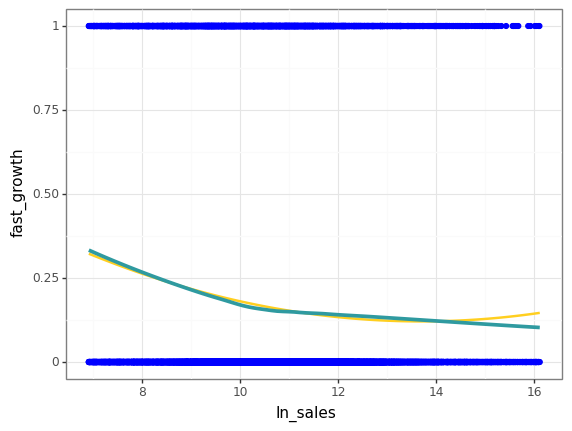

<ggplot: (8782929688185)>

In [44]:
ggplot(data, aes(x = "ln_sales", y = "fast_growth")) + geom_point(
    color = 'blue') + geom_smooth(
    method='lm', formula='y ~ x + I(x**2)',  color=color[3], se = False) + geom_smooth(
    method = "loess", color=color[4], se = False, size=1.5, span=0.9) + labs(
    x="ln_sales", y="fast_growth"
) + theme_bw()

In [45]:
# Linear regressions
ols_s = smf.ols('fast_growth ~ ln_sales + ln_sales_sq', data = data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     153.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           8.76e-67
Time:                        17:47:49   Log-Likelihood:                -9536.0
No. Observations:               21723   AIC:                         1.908e+04
Df Residuals:                   21720   BIC:                         1.910e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9399      0.075     12.614      

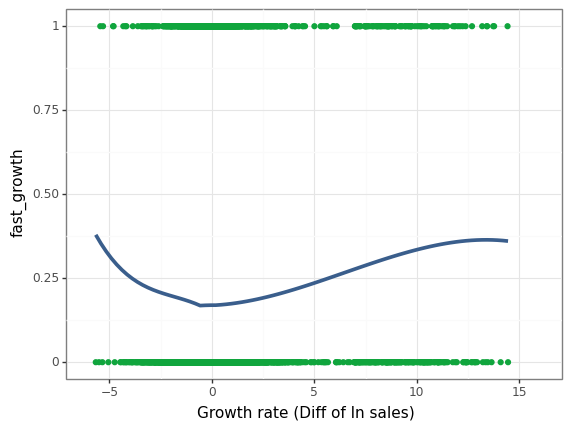

<ggplot: (8782889852450)>

In [46]:
ggplot(data, aes(x = 'diff_ln_sales', y = 'fast_growth')) + geom_point(
    color=color[1]) + geom_smooth(
    method = 'loess', color=color[0], se = False, size=1.5, span=0.9) + labs(
    x='Growth rate (Diff of ln sales)', y='fast_growth') + scale_x_continuous(
    limits=(-6, 16), breaks = seq(-5, 16, by = 5)
) + theme_bw() 

The shape is weird now. Let us look on the values from 0 to 8. We expect *fast_growth* to increase as growth rate is increasing

I will winsorize *diff_ln_sales*: 
1. Replace values below -0.5 with -0.5
2. Replace values above 14 with 14

In [47]:
# generate winsorized variables 

data['flag_low_diff_ln_sales'] = np.where(data['diff_ln_sales'] < -0.5, 1, 0)
data['flag_high_diff_ln_sales'] = np.where(data['diff_ln_sales'] > 14, 1, 0)
data['diff_ln_sales_mod'] = np.where(data['diff_ln_sales'] < -0.5, -0.5, 
                                        np.where(data['diff_ln_sales'] > 14, 14, data['diff_ln_sales']))
data['diff_ln_sales_mod_sq'] = data['diff_ln_sales_mod']**2

Below I depict how winsorized variable looks like:

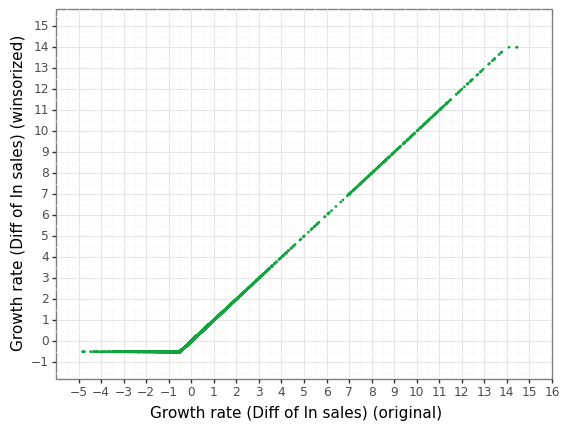

<ggplot: (8782908583551)>

In [48]:
ggplot(data, aes(x = 'diff_ln_sales', y = 'diff_ln_sales_mod')) + geom_point(
    size = 0.1, color = color[1]) + labs(
    x='Growth rate (Diff of ln sales) (original)', y='Growth rate (Diff of ln sales) (winsorized)'
) + scale_x_continuous(limits=(-5, 15), breaks = seq(-5, 17, by = 1)
) + scale_y_continuous(limits=(-1, 15), breaks = seq(-1, 17, by = 1)
) + theme_bw()  

In [49]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset = ['liq_assets_bs', 'foreign', 'ind'])

In [50]:
# drop missing
data = data.dropna(subset = ['age', 'foreign', 'material_exp_pl', 'm_region_loc'])
data['age'].describe()

count    19045.000000
mean         8.701339
std          6.924812
min          0.000000
25%          2.000000
50%          7.000000
75%         15.000000
max         34.000000
Name: age, dtype: float64

In [51]:
# drop unused factor levels
for col in data.select_dtypes(include=['category']).columns:
    data[col] = data[col].cat.remove_unused_categories()

In [52]:
data = data.reset_index()

In [53]:
# drop unnecessary columns
data = data.drop(['index','d1_ln_sales', 'd2_ln_sales', 'exit_date' , 'birth_year', 'exit_year'], axis=1)

In [54]:
data.to_csv(data_out+'bisnode_firms_clean.csv',index=False)

The final data has 19,036 observations

In [55]:
data.describe()

,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,...,flag_miss_labor_avg,ln_sales_sq,ROE,ROA,ROTA,CR,flag_low_diff_ln_sales,flag_high_diff_ln_sales,diff_ln_sales_mod,diff_ln_sales_mod_sq
count,1.904500e+04,1.904500e+04,1.903600e+04,1.903600e+04,19045.000000,1.904500e+04,1.904500e+04,1.903600e+04,1.904500e+04,1.903600e+04,...,19045.000000,19045.000000,19045.000000,19045.000000,19045.000000,19045.000000,19045.000000,19045.000000,19045.000000,19045.000000
mean,1.529528e+11,9.270972e+03,9.914862e+04,8.567028e+04,417.819625,1.641118e+03,1.219623e+03,1.451590e+05,5.863911e+03,3.365268e+03,...,0.135994,118.628945,0.690792,-7.707517,-7.545223,10.174791,0.116776,0.000158,0.186913,1.600895
std,1.377226e+11,4.973874e+04,4.377075e+05,4.202974e+05,7140.248047,3.282766e+04,3.211808e+04,1.105861e+06,1.305331e+05,5.193336e+04,...,0.342791,37.738092,20.577446,323.470951,323.217576,284.752163,0.321162,0.012550,1.251416,11.877037
min,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1418.518555,-1.740741e+02,-2.484481e+05,0.000000e+00,-1.091879e+07,0.000000e+00,...,0.000000,47.717083,-591.624985,-39847.001446,-39847.001446,0.000000,0.000000,0.000000,-0.500000,0.000000
25%,2.869650e+10,1.185185e+02,3.314815e+03,3.822222e+03,0.000000,0.000000e+00,0.000000e+00,1.074074e+02,-6.518519e+03,0.000000e+00,...,0.000000,92.676344,0.008885,-0.435821,-0.365586,0.759082,0.000000,0.000000,-0.173476,0.000695
50%,1.143081e+11,8.814815e+02,1.146852e+04,1.485185e+04,0.000000,0.000000e+00,0.000000e+00,4.600000e+03,2.370370e+02,0.000000e+00,...,0.000000,114.270839,0.181087,0.006538,0.032090,1.085480,0.000000,0.000000,0.000000,0.025891
75%,2.556270e+11,4.070370e+03,4.023333e+04,4.803796e+04,0.000000,0.000000e+00,0.000000e+00,3.940926e+04,4.062963e+03,0.000000e+00,...,0.000000,139.695685,0.616709,0.097421,0.157610,2.564171,0.000000,0.000000,0.148790,0.190318
max,4.641050e+11,3.570863e+06,1.874527e+07,3.660118e+07,666300.000000,3.266667e+06,3.253704e+06,1.036673e+08,4.378226e+06,3.409752e+06,...,1.000000,259.758533,1633.545408,178.250002,287.400005,33519.002903,1.000000,1.000000,14.000000,196.000000


# Part I: Probability prediction

## Define helper functions

In [56]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def coef_matrix(X, model):

    coef_matrix = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix = coef_matrix.append({'variable': 'Intercept', 'coefficient': np.asscalar(model.intercept_)}, ignore_index=True)
    return(coef_matrix)

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

## Define variable sets 

In [57]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap", "amort"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl", "ROE", "ROA", "ROTA", "CR"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3=[]
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["diff_ln_sales_mod", "diff_ln_sales_mod_sq",
         "flag_low_diff_ln_sales", "flag_high_diff_ln_sales"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [58]:
#Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)

m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1]'], axis=1)

In [59]:
# Define X1
basevars = data[["ln_sales", "ln_sales_sq", "diff_ln_sales_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)

# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Define X3
firm = pd.concat([data[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([data[["ln_sales", "ln_sales_sq"] + engvar + d1], firm], axis=1)

# Define X4
X4 = pd.concat([data[["ln_sales", "ln_sales_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [60]:
# Define X5
#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):diff_ln_sales_mod \
                + C(ind2_cat):ln_sales + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", data, return_type="dataframe")
#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26.0]') or col.endswith('C(urban_m)[1.0]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + ln_sales:age + ln_sales:female + ln_sales:profit_loss_year_pl \
                + ln_sales:foreign_management", data, return_type="dataframe")
X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [61]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [62]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["sales", "diff_ln_sales"] + rawvars + hr + qualityvars], firm], axis=1)

In [63]:
y = data['fast_growth']

In [64]:
X1.head()

,ln_sales,ln_sales_sq,diff_ln_sales_mod,profit_loss_year_pl,C(ind2_cat)[27.0],C(ind2_cat)[28.0],C(ind2_cat)[29.0],C(ind2_cat)[30.0],C(ind2_cat)[33.0],C(ind2_cat)[55.0],C(ind2_cat)[56.0]
0,7.093159,50.312898,7.093159,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,13.943477,194.420551,0.684448,0.008554,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.932070,62.917730,-0.500000,-0.840425,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,12.980031,168.481216,0.097722,0.223102,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,11.773208,138.608422,-0.273087,-0.018129,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Check simple linear and logistic models

In [65]:
# Check simplest model X1
X1.fillna(X1.mean(), inplace=True)
ols_modelx1 = LinearRegression().fit(X1, y)

In [66]:
regression_results(y, ols_modelx1.predict(X1))

explained_variance:  0.0196
r2:  0.0196
MAE:  0.2715
MSE:  0.1357
RMSE:  0.3684


In [67]:
glm_modelx1 = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X1, y)
regression_results(y, glm_modelx1.predict(X1))

explained_variance:  -0.004
r2:  -0.2014
MAE:  0.1663
MSE:  0.1663
RMSE:  0.4079


In [68]:
# Check model X2
X2.fillna(X2.mean(), inplace=True)
glm_modelx2 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X2, y)
regression_results(y, glm_modelx2.predict(X2))

explained_variance:  -0.0098
r2:  -0.2033
MAE:  0.1666
MSE:  0.1666
RMSE:  0.4082


In [69]:
coef_matrix(X2, glm_modelx2)

,variable,coefficient
0,ln_sales,-0.444435
1,ln_sales_sq,0.013395
2,diff_ln_sales_mod,0.092421
3,profit_loss_year_pl,-0.318503
4,C(ind2_cat)[27.0],0.062993
5,C(ind2_cat)[28.0],0.041340
6,C(ind2_cat)[29.0],0.517547
7,C(ind2_cat)[30.0],0.234020
8,C(ind2_cat)[33.0],-0.004905
9,C(ind2_cat)[55.0],-0.259803


In [70]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
mx2.summary()

Optimization terminated successfully.
         Current function value: 0.429157
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ln_sales                   -0.0589      0.015     -3.970      0.000      -0.088      -0.030
ln_sales_sq                 0.0018      0.001      2.585      0.010       0.000       0.003
diff_ln_sales_mod           0.0123      0.002      7.253      0.000       0.009       0.016
profit_loss_year_pl        -0.0422      0.008     -5.114      0.000      -0.058      -0.026
C(ind2_cat)[27.0]           0.0083      0.019      0.443      0.658      -0.029       0.045
C(ind2_cat)[28.0]           0.0055      0.014      0.378      0.705      -0.023       0.034
C(ind2_cat)[29.0]           0.0686      0.023      2.989      0.003       0.024       0.114
C(ind2_cat)[30.0]           0.0310      0.030      1.048      0.294      -0.027       0.089
C(ind2_cat)[33.0]          -0.0007      0.014     -0.046      0.964      -0.029       0.027
C(ind2_cat)[55.0]          -0.0344      0.014     -2.380      0.017      -0.063      -0.006
C(ind2_cat)[56.0]          -0.0485      0.013     -3.840      0.000      -0.073      -0.024
fixed_assets_bs             0.0257      0.008      3.039      0.002       0.009       0.042
share_eq_bs                 0.0325      0.007      4.753      0.000       0.019       0.046
curr_liab_bs                0.0461      0.012      3.964      0.000       0.023       0.069
curr_liab_bs_flag_high     -0.0395      0.010     -3.885      0.000      -0.059      -0.020
curr_liab_bs_flag_error     0.0580      0.108      0.537      0.591      -0.154       0.269
age                        -0.0084      0.000    -18.332      0.000      -0.009      -0.007
foreign_management          0.0124      0.009      1.431      0.153      -0.005       0.029
===========================================================================================
"""

In [71]:
# Check model X3
X3.fillna(X3.mean(), inplace=True)
glm_modelx3 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X3, y)
regression_results(y, glm_modelx3.predict(X3))

explained_variance:  -0.0124
r2:  -0.1942
MAE:  0.1653
MSE:  0.1653
RMSE:  0.4066


In [72]:
# Check model X4
X4.fillna(X4.mean(), inplace=True)
glm_modelx4 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X4, y)
regression_results(y, glm_modelx4.predict(X4))

explained_variance:  -0.0136
r2:  -0.1691
MAE:  0.1619
MSE:  0.1619
RMSE:  0.4023


In [73]:
# Check model X5
X5.fillna(X5.mean(), inplace=True)
glm_modelx5 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X5, y)
regression_results(y, glm_modelx5.predict(X5))

explained_variance:  -0.0026
r2:  -0.154
MAE:  0.1598
MSE:  0.1598
RMSE:  0.3997


## Separate train and holdout data

In [74]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=round(0.8*len(data.index)), random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [75]:
print('Total')
print(data['fast_growth'].value_counts(normalize=True))
print('Train')
print(data.iloc[index_train]['fast_growth'].value_counts(normalize=True))
print('Holdout')
print(data.iloc[index_holdout]['fast_growth'].value_counts(normalize=True))

Total
0    0.833972
1    0.166028
Name: fast_growth, dtype: float64
Train
0    0.833486
1    0.166514
Name: fast_growth, dtype: float64
Holdout
0    0.835915
1    0.164085
Name: fast_growth, dtype: float64


## PREDICT PROBABILITIES

In [76]:
#specify cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

## Train logit models

In [77]:
# no regularisation needed so setting the paremeter to very high value
C_value_logit=[1e20]

In [78]:
# Train Logit Models ----------------------------------------------
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='neg_brier_score', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).tolist()

## Lasso logit

In [79]:
normalized_logitvars=pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns=logitvars.columns

In [80]:
lambdas=list(10**np.arange(-1,-4.01, -1/3))
n_obs = normalized_logitvars.shape[0]*4/5
C_values = [1/(l*n_obs) for l in lambdas]

logLasso = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='accuracy', solver='liblinear',
                             random_state=42)

In [83]:
normalized_logitvars.fillna(normalized_logitvars.mean(), inplace=True)
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

In [84]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000820,0.833487
1,0.046416,0.001768,0.833487
2,0.021544,0.003808,0.833487
3,0.010000,0.008204,0.835784
4,0.004642,0.017676,0.835849
5,0.002154,0.038081,0.836834
6,0.001000,0.082043,0.837096
7,0.000464,0.176755,0.836768
8,0.000215,0.380808,0.837228
9,0.000100,0.820425,0.837031


In [85]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]

In [86]:
coef_matrix(normalized_logitvars, logit_models["LASSO"])

,variable,coefficient
0,ln_sales,-0.292380
1,ln_sales_sq,0.000000
2,total_assets_bs,0.066236
3,fixed_assets_bs,0.122285
4,liq_assets_bs,0.084736
...,...,...
160,ln_sales:age,-0.024293
161,ln_sales:female,-0.065547
162,ln_sales:profit_loss_year_pl,-0.031438
163,ln_sales:foreign_management,0.157836


In [87]:
#refit with negative brier score so we have RMSE values for the same cv split
logLasso_brier = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='neg_brier_score', 
                            solver="liblinear", random_state=42)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [88]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['LASSO'] = np.sqrt(-1*(logLasso_brier_fitted.scores_[1][:,i])).tolist()

Let's see what we have now. Compare 6 models X1 to X5 and a Lasso one.

I will compare models by Average CV RMSE (average for five folds)

In [89]:
CV_RMSE_wo_loss = dict()

for key in logit_models:
    CV_RMSE_wo_loss[key] = np.mean(CV_RMSE_folds[key])

In [90]:
summary_results = pd.DataFrame({
    "Model": list(CV_RMSE_folds.keys()),
    "CV RMSE": list(CV_RMSE_wo_loss.values())
                               })
summary_results

,Model,CV RMSE
0,X1,0.369202
1,X2,0.364582
2,X3,0.361908
3,X4,0.359364
4,X5,0.359817
5,LASSO,0.359821


As we can see, for now Models 4 and 5 are very comparable, but 5 is more complicated. The difference in CVRMSE might as well be due to the inherent randomness (CVRMSE itself is a random variable here due to the fact that it depends on the random split of the sample), but it is preferable to model 5, because it is less complex

## No loss fn

In [91]:
# Calculate AUC for each folds --------------------------------
CV_AUC_folds = dict()

#refit logit models with AUC so we have AUC values for the same cv split
for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='roc_auc', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [92]:
#refit with AUC so we have AUC values for the same cv split
logLasso_auc = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='roc_auc', 
                            solver="liblinear", random_state=42)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)
CV_AUC_folds['LASSO'] = logLasso_auc_fitted.scores_[1][:,best_lambda_i].tolist()

In [93]:
# For each model: average RMSE and average AUC for models ----------------------------------
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])
    
for key in logit_models:
    if key != 'LASSO':
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [94]:
# We have 6 models, (5 logit and the logit lasso). For each we have a 5-CV RMSE and AUC.
# We pick our preferred model based on that. -----------------------------------------------
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']

In [95]:
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,11.0,0.369202,0.597642
X2,18.0,0.364582,0.645786
X3,39.0,0.361908,0.663511
X4,83.0,0.359364,0.669700
X5,164.0,0.359817,0.669209
LASSO,131.0,0.359821,0.669833


In [96]:
# Take best model and estimate RMSE on holdout  -------------------------------------------
# X4, X5 and LASSO are practically the same - go with the simplest model 

best_model = logit_models['X4']
best_model_X_holdout = X4.iloc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.358

In [97]:
# discrete ROC (with thresholds in steps) on holdout -------------------------------------------------

thresholds = seq(0.05, 0.8, by = 0.05)
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [98]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {'thresholds': thresholds,
     'true_positive_rates': true_positive_rates,
     'false_positive_rates': false_positive_rates})

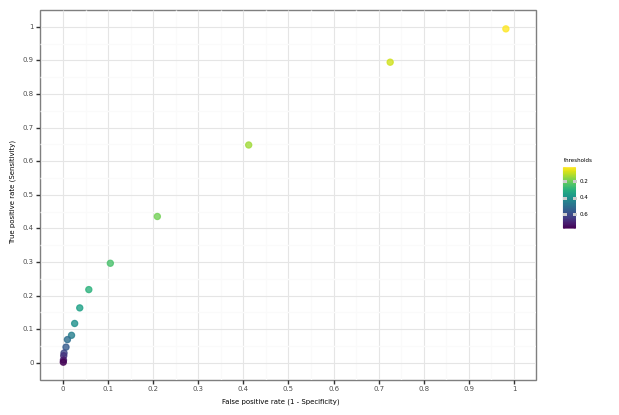

<ggplot: (8782889622498)>

In [99]:
ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
        + labs(x = "False positive rate (1 - Specificity)", y = "True positive rate (Sensitivity)")\
        + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
        + scale_x_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + scale_y_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + theme_bw()\
        +theme(legend_position="right",
            axis_text=element_text(size=5),
            axis_title=element_text(size=5),
            legend_text = element_text(size = 4),
            legend_title = element_text(size = 4),
            legend_key_size=6)

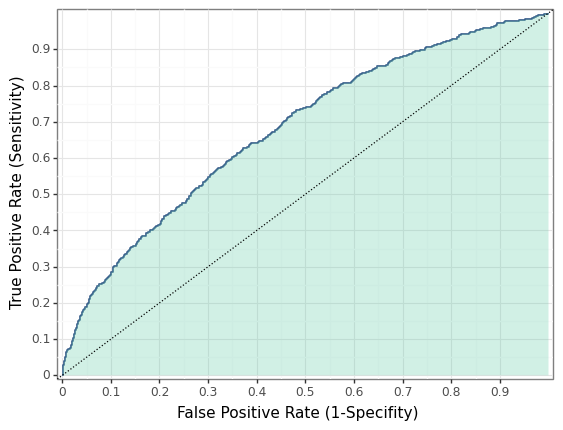

<ggplot: (8782908557725)>

In [100]:
# continuous ROC on holdout with best model (Logit 4) -------------------------------------------

create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

In [101]:
# Confusion table with different thresholds ----------------------------------------------------------

# default: the threshold 0.5 is used to convert probabilities to binary classes
logit_class_prediction = best_model.predict(best_model_X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0],' (no fast growth): ',counts[0])
print(values[1],' (fast growth): ',counts[1])

0  (no fast growth):  3735
1  (fast growth):  74


In [102]:
# confusion matrix: summarize different type of errors and successfully predicted cases
# positive = "yes": explicitly specify the positive case
cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0,1])
cm1 = pd.DataFrame(cm_object1, 
    index=['Actual not fast-growing', 'Actual fast-growing'], 
    columns=['Predicted not fast-growing', 'Predicted fast-growing'])
cm1

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,3153,31
Actual fast-growing,582,43


In [103]:
# we can apply different thresholds

threshold = 0.3
holdout_prediction = np.where(logit_predicted_probabilities_holdout < threshold, 0, 1)
cm_object1b = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm1b = pd.DataFrame(cm_object1b, 
    index=['Actual not fast-growing', 'Actual fast-growing'], 
    columns=['Predicted not fast-growing', 'Predicted fast-growing'])
cm1b

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,3002,182
Actual fast-growing,489,136


In [104]:
# a sensible choice: mean of predicted probabilities
mean_predicted_fast_growth_prob = np.mean(logit_predicted_probabilities_holdout)
round(mean_predicted_fast_growth_prob, 3)

0.166

In [105]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < mean_predicted_fast_growth_prob, 0, 1)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm2 = pd.DataFrame(cm_object2, 
    index=['Actual not fast-growing', 'Actual fast-growing'], 
    columns=['Predicted not fast-growing', 'Predicted fast-growing'])
cm2

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,2137,1047
Actual fast-growing,266,359


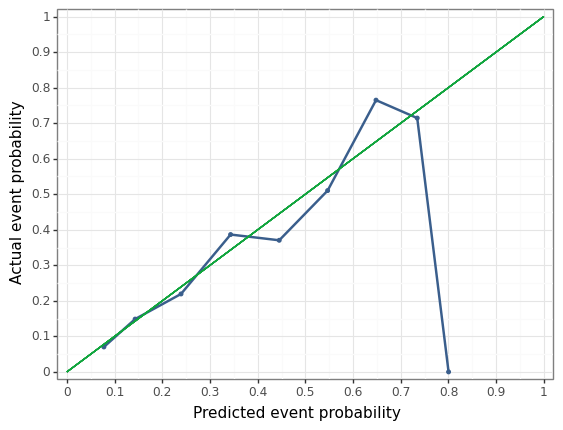

<ggplot: (8782908142818)>

In [106]:
# Calibration curve -----------------------------------------------------------
# how well do estimated vs actual event probabilities relate to each other?

holdout = pd.concat([best_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
create_calibration_plot(holdout, file_name = "ch17-figure-1-logit-m4-calibration",\
                        prob_var='best_logit_no_loss_pred', actual_var='fast_growth',\
                        y_lab="Actual event probability", n_bins=10, breaks=None)

# PART II: Classification

## We have a loss function

Now I need to define the cost of false negative and false positive

Let's see the growth rate of fast-growing firms and non-fast-growing firms

In [107]:
print("The sales growth rate of fast-growing firms is {:.2f} percent".format(
    data.groupby(['fast_growth'])['d1_sales'].median()[1]*100))
print("The sales growth rate of non-fast-growing firms is {:.2f} percent".format(
    data.groupby(['fast_growth'])['d1_sales'].median()[0]*100))

The sales growth rate of fast-growing firms is 78.30 percent
The sales growth rate of non-fast-growing firms is -6.36 percent


Suppose I have 1000 EUR and I want to invest in firms. 

If I invest in fast-growing firm, I will get 1783 EUR on average (assuming sales growth rate is 1-to-1 correlated with the profit you get as an investor)

If I invest in non-fast-growing firm, I will get 936 EUR on average (assuming sales growth rate is 1-to-1 correlated with the profit you get as an investor)

That is why FP = 1780, FN = 936

In [108]:
# Introduce loss function
# relative cost of of a false negative classification (as compared with a false positive classification)
FP = 1781
FN = 937
cost = FN/FP
# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum()/len(y_train)

In [109]:
# Draw ROC Curve and find optimal threshold with loss function --------------------------
# The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss =[]
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(list(zip(
            np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       thresholds)), key=lambda i: i[0], reverse=True)[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

In [110]:
logit_summary2 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary2['Threshold for Fold5'] = fold5_threshold.values()
logit_summary2['Avg expected loss'] = expected_loss_cv.values()
logit_summary2['Expected loss for Fold5'] = fold5_expected_loss.values()

In [111]:
logit_summary2

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,1.130123,1.542663,155.900093,162.983262
1,X2,1.188185,1.603432,155.887864,162.983262
2,X3,1.274898,1.986992,155.949371,162.983262
3,X4,0.637328,0.670993,154.394153,162.307187
4,X5,0.889903,1.999953,154.801142,162.983262
5,LASSO,0.920649,1.999922,155.095905,162.983262


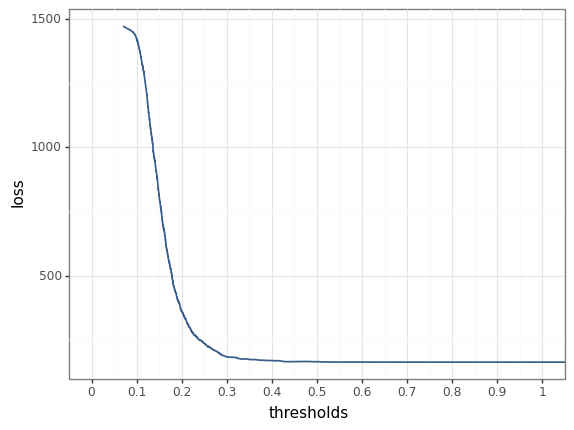

<ggplot: (8782928483434)>

In [112]:
# Create loss plot based on Fold5 in CV ----------------------------------------------
# select model to plot
model_to_plot = 'X1'
create_loss_plot(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot], fold5_expected_loss[model_to_plot])

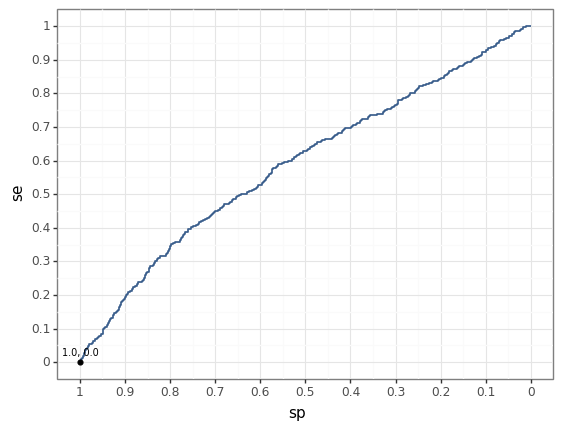

<ggplot: (8782928467050)>

In [113]:
# Create roc plot plot based on Fold5 in CV ----------------------------------------------
# select model to plot
model_to_plot = 'X1'
create_roc_plot_with_optimal(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot])

In [114]:
# Pick best model based on average expected loss ----------------------------------
#X4
best_logit_optimal_threshold = best_thresholds_cv["X4"]

# Get expected loss on holdout
holdout_threshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_threshold, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_threshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

152.888

In [115]:
cm_object3 = confusion_matrix(y_holdout, holdout_threshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actual not fast-growing', 'Actual fast-growing'], 
    columns=['Predicted not fast-growing', 'Predicted fast-growing'])
cm3

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,3179,5
Actual fast-growing,612,13


# PREDICTION WITH RANDOM FOREST

In [118]:
rfvars.fillna(rfvars.mean(), inplace=True)
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

## Graph example

<Figure size 640x480 with 0 Axes>

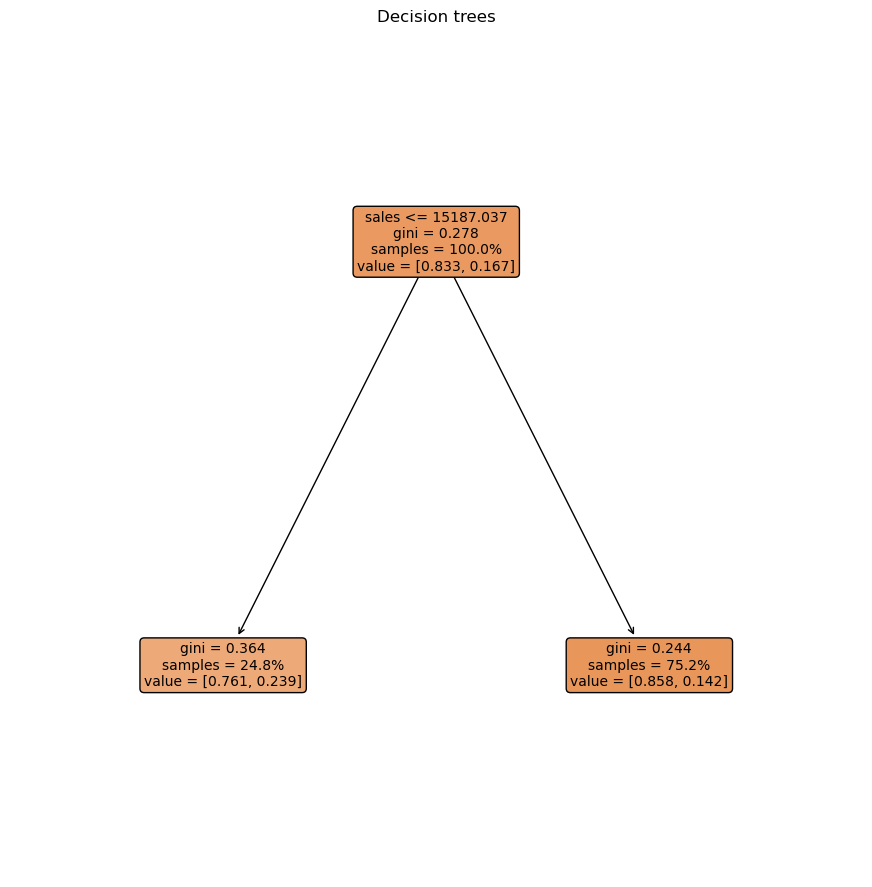

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = rfvars_train[['sales','profit_loss_year','foreign_management']]
rf_for_graph = DecisionTreeClassifier(ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41).fit(
    data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11,11))
plot_tree(rf_for_graph, 
          feature_names = data_for_graph.columns, filled=True, rounded=True, proportion=True, fontsize = 10)
plt.title("Decision trees")
plt.show() 

## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [120]:
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]} #1 more than in R because here condition for min node size is >= while > in R 

In [121]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(prob_forest, grid, cv=k, refit='accuracy',
                                scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)

In [122]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

In [123]:
#create CV summary table
cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5

cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5

cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5

prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [124]:
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.839262,0.673936,0.358153
1,5,16,0.839656,0.674524,0.357880
2,6,11,0.839590,0.673340,0.358278
3,6,16,0.839722,0.674963,0.358013
4,7,11,0.839394,0.671758,0.358561
5,7,16,0.840312,0.673676,0.358234


In [125]:
#obtain optimal parameter values
best_mtry = prob_forest_fit.best_params_['max_features']
best_min_node_size = prob_forest_fit.best_params_['min_samples_split']
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 16}

In [126]:
# Get average (ie over the folds) RMSE and AUC ------------------------------------
prob_forest_best_results = prob_forest_cv_results[(prob_forest_cv_results.max_features == best_mtry) & 
                      (prob_forest_cv_results.min_samples_split == best_min_node_size)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE['rf_p'] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC['rf_p'] = prob_forest_best_results.cv_auc.values[0]

In [127]:
# Get fold level RMSE and AUC ------------------------------------

CV_RMSE_folds_rf_p = list()
for i in range(5):
    rmse = np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)
CV_RMSE_folds['rf_p'] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()
for i in range(5):
    rmse = prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc'][prob_forest_best_results_index]
    CV_AUC_folds_rf_p.append(rmse)
CV_AUC_folds['rf_p'] = CV_AUC_folds_rf_p

In [128]:
# Now use loss function and search for best thresholds and expected loss over folds -----
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    prob_forest_best = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True,
                    criterion = 'gini', max_features = best_mtry, min_samples_split = best_min_node_size)
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(list(zip(np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       threshold)), key=lambda x: x[0], reverse=True)[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)
    
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [129]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [130]:
expected_loss_cv['rf_p'] = np.mean(expected_loss)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds)

In [131]:
rf_summary = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE['rf_p'], 3)],
     'CV AUC': [round(CV_AUC['rf_p'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.358,0.674,0.631,0.561,152.993,158.035


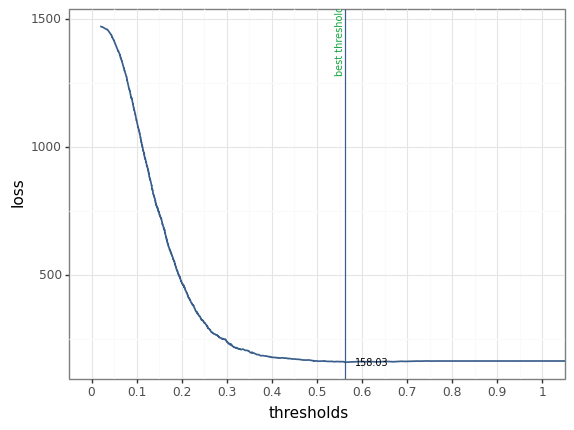

<ggplot: (8782942056888)>

In [132]:
# Create plots based on Fold5 in CV ----------------------------------------------
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

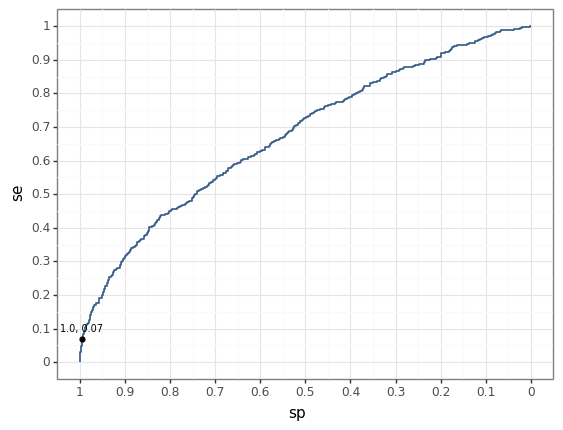

<ggplot: (8782908370408)>

In [133]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

In [134]:
# Take model to holdout and estimate RMSE, AUC and expected loss ------------------------------------
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.357

In [135]:
# ROC AUC  on holdout
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.678

In [136]:
# Get expected loss on holdout
holdout_threshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_threshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

151.166

In [137]:
cm_object4 = confusion_matrix(y_holdout, holdout_threshold, labels=[0,1])
cm4 = pd.DataFrame(cm_object4, 
    index=['Actual not fast-growing', 'Actual fast-growing'], 
    columns=['Predicted not fast-growing', 'Predicted fast-growing'])
cm4

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,3179,5
Actual fast-growing,605,20


## Final results

In [138]:
#Note: in R length(rfvars) counts 1 for category variables (39), here they count category number-1 (44)
nvars['rf_p'] = len(rfvars.columns)

In [139]:
summary_results = pd.DataFrame({"Model": list(nvars.keys()),
                              "Number of predictors": list(nvars.values()),
                              "CV RMSE": list(CV_RMSE.values()),
                              "CV AUC": list(CV_AUC.values()),
                              "CV threshold": list(best_thresholds_cv.values()),
                              "CV expected Loss": list(expected_loss_cv.values())
                               })

# PART III Discussion of results

In [140]:
summary_results

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,11,0.369202,0.597642,1.130123,155.900093
1,X2,18,0.364582,0.645786,1.188185,155.887864
2,X3,39,0.361908,0.663511,1.274898,155.949371
3,X4,83,0.359364,0.669700,0.637328,154.394153
4,X5,164,0.359817,0.669209,0.889903,154.801142
5,LASSO,131,0.359821,0.669833,0.920649,155.095905
6,rf_p,45,0.358234,0.673676,0.630669,152.992638


Summary results show us that the random forest gives the less expected loss.

To understand how random forest predicts the fast growing firms, let’s look on the confusion matrix.

In [141]:
# confusion matrix for random forest
cm4

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,3179,5
Actual fast-growing,605,20


In [142]:
# confusion matrix for Model 4, threshold = 0.3
cm1b

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,3002,182
Actual fast-growing,489,136


Now return to our investor example. The model predicted that there are 25 fast-growing firms. Suppose I invest 1000 EUR to each company. I will spend 25,000 EUR and get in return $5*937 + 20*1781 = 40,305$ EUR. That is a whooping $61.22$% return.

Now suppose that I did not have a loss function. The benchmark model was Model 4, and the threshold = 0.3. Suppose I invest 1000 EUR to each company. I will spend 318,000 EUR and get in return $182*937 + 136*1781 = 412,750$ EUR. That is $29.8$% return, which is much less than in previous case, by a great margin. 

This is how relevant the model can be, especially if financing is not abundant, and investors are quite risk averse. What we are doing is that we are essentially increaing the rate of return on investment by being more selective.

Having more domain knowledge of the industries in which these firms operate and of accounting would allow to specify more fitting loss functions. One this that could be done is splitting firm by industry and grouping similar ones together. When I say similar I mean in accounting terms. e.g. firms in retail, food, or any industry that requires a lot of inventory turnover require a high level of working capital as a percentage of total assets, whilst that is the opposite for firms in construction for example. The point of all of this is that the same number on the balance sheet could mean a very different thing depending on industry. While it is true that we could control for industry and that would be the end of that, but it would make more sense for investors to have a model for each industry group as it fits well with the way that portfolio managers think and it would be a lot easier for them to use and to convince others of their choices. 